In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generating a trajectory

In [2]:
a = np.array([0,0,0]).astype('float')

In [3]:
b = np.array([1,0,0]).astype('float')

In [4]:
def generate_trajectory(a, b, shift, step):
    t = a.copy()
    c = (a+b)/2
    c[2] -= shift
    points = []
    d_ab = np.linalg.norm(a-b)
    while(t[2] >= b[2]):
        points.append(t.copy())
        z_d = np.dot(a[:2]-b[:2], t[:2]-c[:2])/(t[2]-c[2])
        d = np.array([b[0]-a[0],b[1]-a[1],z_d])
        unit_d = d/np.linalg.norm(d)
        t += step*unit_d
        new_d_ab = np.linalg.norm(t-b)
        if(new_d_ab > d_ab):
            break
        else:
            d_ab = new_d_ab

    return np.array(points)

In [5]:
points1 = generate_trajectory(a,b,0.25,1e-3)
points2 = generate_trajectory(a,b,0.866,1e-3)

In [6]:
def visualize(points, init, goal):
    n = len(points)
    sr = 10**(np.round(np.log10(n)) - 2)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    xs = [x[0] for i,x in enumerate(points) if i%sr == 0]
    ys = [x[1] for i,x in enumerate(points) if i%sr == 0]
    zs = [x[2] for i,x in enumerate(points) if i%sr == 0]

    ax.scatter(xs, ys, zs)
    ax.scatter(*list(init),marker='x',s=81,label='Start')
    ax.scatter(*list(goal),marker='x',s=81,label='Goal')
    plt.legend()
    plt.show()

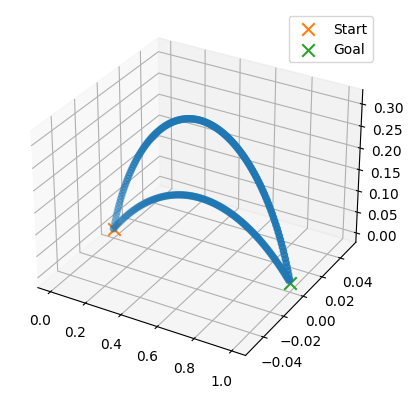

In [7]:
visualize(np.vstack([points1,points2]), a, b)

## Fixing overshooting and shift bug

In [8]:
a = np.array([0,0,0]).astype('float')
b = np.array([0.5,0,0]).astype('float')
c = np.array([1.0,0,0]).astype('float')
d = np.array([1,0,0]).astype('float')

### Two Points Trajectory

In [9]:
def generate_new_trajectory(a, b, shift, step):
    t = a.copy()
    cntr = (a+b)/2
    d_ab = np.linalg.norm(a-b)
    c = shift*d_ab #shift-bug
    cntr[2] -= c
    points = []
    r = np.sqrt(c**2 + (d_ab**2/4))
    theta = np.arcsin(step/(2*r))*2
    theta1 = np.arctan(d_ab/(2*c))*2
    unit_ab = (b-a)/np.linalg.norm(b-a)
    i = 0
    while(t[2] >= b[2]):
        points.append(t.copy())
        curr_theta = (theta1 - ((2*i+1)*theta))/2
        d = unit_ab.copy()
        d[:2] *= np.cos(curr_theta)
        d[2] = np.sin(curr_theta)
        unit_d = d/np.linalg.norm(d)
        t += step*unit_d
        new_d_ab = np.linalg.norm(t-b)
        i += 1
        if(new_d_ab > d_ab):
            break
        else:
            d_ab = new_d_ab
    
    points.append(b.copy())

    return np.array(points)

In [10]:
points1 = generate_new_trajectory(a,b,0.25,1e-2)
points2 = generate_new_trajectory(a,b,0.2,1e-2)

In [11]:
def visualize(points, init, goal):
    n = len(points)
    sr = 10**(np.round(np.log10(n)) - 2)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    xs = [x[0] for i,x in enumerate(points) if i%sr == 0]
    ys = [x[1] for i,x in enumerate(points) if i%sr == 0]
    zs = [x[2] for i,x in enumerate(points) if i%sr == 0]

    ax.scatter(xs, ys, zs)
    ax.scatter(*list(init),marker='x',s=81,label='Start')
    ax.scatter(*list(goal),marker='x',s=81,label='Goal')
    plt.legend()
    plt.show()

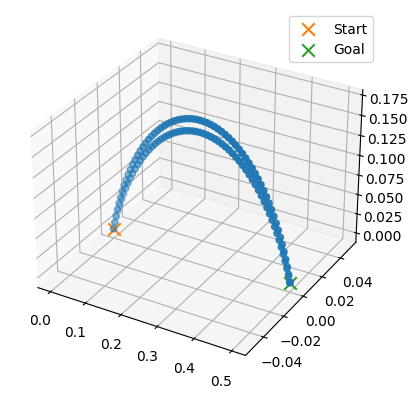

In [12]:
visualize(np.vstack([points1,points2]), a, b)

### Three Points Trajectory

In [15]:
def generate_three_point_trajectory(a, b, c, shift, step):
    path_ab = generate_new_trajectory(a, b, shift, step)
    path_bc = generate_new_trajectory(b, c, shift, step)
    return np.concatenate((path_ab, path_bc[1:]))  # We remove the first point of path_bc to avoid duplicating point 'b'

In [16]:
def visualize_three(points, a, b, c):
    n = len(points)
    sr = 10**(np.round(np.log10(n)) - 2)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    xs = [x[0] for i,x in enumerate(points) if i%sr == 0]
    ys = [x[1] for i,x in enumerate(points) if i%sr == 0]
    zs = [x[2] for i,x in enumerate(points) if i%sr == 0]

    ax.scatter(xs, ys, zs)
    ax.scatter(*list(a), marker='x', s=81, label='Start')
    ax.scatter(*list(b), marker='o', s=81, label='Middle')  # added this line
    ax.scatter(*list(c), marker='x', s=81, label='Goal')
    
    plt.legend()
    plt.show()

In [17]:
points3 = generate_three_point_trajectory(a,b,c,0.25,1e-2)

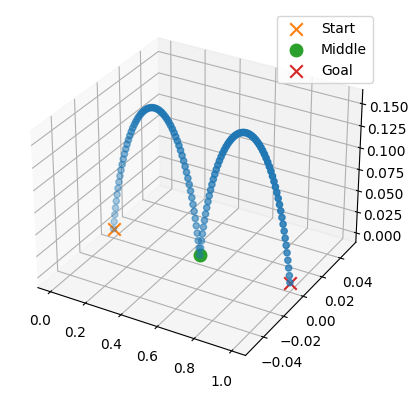

In [18]:
visualize_three(points3, a, b, c)

# New data generation

#### (0,1) is Down and (1,0) is Right

### libfranka A->B

### Pick and Place Three Point Trajectory Data Generation (No Noise Added - Jacob)

In [13]:
import os
os.chdir('..')

from src.data.old_dataset import EpisodicDataset, Episode, Step
import pickle

In [14]:
# inits = np.array([[0.335, -0.02, -0.07], [0.433, -0.02, -0.07], [0.335, -0.1, -0.07], [0.335, 0.07, -0.07], [0.412, -0.06, -0.07]])
# goals = np.array([[0.537, -0.02, -0.07],[0.335, -0.19, -0.07]])
has = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

In [15]:
import copy

def add_noise(traj, sigma, ratio):
    new_traj = copy.deepcopy(traj)
    steps_affected = np.random.randint(0, len(new_traj), size=int(len(new_traj)*ratio))
    for step in steps_affected:
        noise = np.random.normal(0, sigma, 3)
        new_traj[step] += noise

    return new_traj

In [30]:
init = np.array([0.335, -0.02, -0.07]).astype('float')
g1 = np.array([0.537, -0.02, -0.07]).astype('float')
ha = np.array([0,0,0,0]).astype('float')
epi_ds = EpisodicDataset()
time = 1.0
for shift in np.arange(0.15,0.251,0.002):
    curr_epi = Episode()
    curr_points = generate_new_trajectory(init, g1, shift, 1e-2)
    for pt_i in range(len(curr_points)-1):
        curr_step = Step(joint_velocity=np.array([]), 
                            ee_velocity=np.array((curr_points[pt_i+1]-curr_points[pt_i])), 
                            context = {'ee_pos':curr_points[pt_i].copy()})
        curr_step.ee_velocity /= np.linalg.norm(curr_step.ee_velocity)
        curr_step.human_action = ha.copy()
        curr_epi.steps.append(curr_step)
    epi_ds.episodes.append(curr_epi)

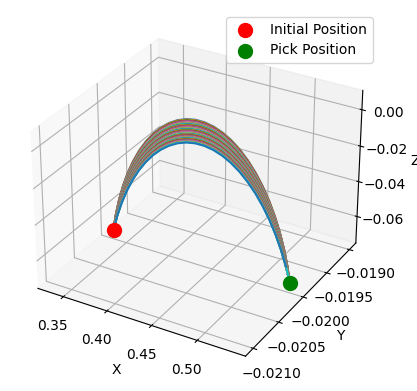

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# For each episode
for epi in epi_ds.episodes:
    xs = []
    ys = []
    zs = []

    # For each step in the episode
    for step in epi.steps:
        # Extract the position
        pos = step.context['ee_pos']

        # Append the coordinates to their respective lists
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])

    # Plot the trajectory for this episode
    ax.plot(xs, ys, zs)

# Mark the initial, intermediate and final positions
ax.scatter(*init, color='r', s=100, label='Initial Position')
ax.scatter(*g1, color='g', s=100, label='Pick Position')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.legend()
plt.show()


In [32]:
test_idxs = np.random.choice(np.arange(len(epi_ds.episodes)), size=int(0.1*len(epi_ds.episodes)), replace=False)
epi_ds_test = EpisodicDataset()
epi_ds_test.episodes = [x for i,x in enumerate(epi_ds.episodes) if i in test_idxs]
epi_ds.episodes = [x for i,x in enumerate(epi_ds.episodes) if i not in test_idxs]

In [33]:
train_data, train_label = [], []
for epi in epi_ds.episodes:
    for st in epi.steps:
        train_data.append(np.hstack((st.human_action, st.context['ee_pos'])))
        train_label.append(st.ee_velocity)
        
train_data = np.array(train_data)
train_label = np.array(train_label)

In [34]:
test_data, test_label = [], []
for epi in epi_ds_test.episodes:
    for st in epi.steps:
        test_data.append(np.hstack((st.human_action, st.context['ee_pos'])))
        test_label.append(st.ee_velocity)
        
test_data = np.array(test_data)
test_label = np.array(test_label)

In [35]:
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((1213, 7), (1213, 3), (135, 7), (135, 3))

In [15]:
np.save('./src/data/libfranka_joints/unprocessed/A_B_train_data.npy', train_data)
np.save('./src/data/libfranka_joints/unprocessed/A_B_train_label.npy', train_label)
np.save('./src/data/libfranka_joints/unprocessed/A_B_test_data.npy', test_data)
np.save('./src/data/libfranka_joints/unprocessed/A_B_test_label.npy', test_label)

# Previous Two Point Data Generation (Shivam)

In [ ]:
# epi_ds = EpisodicDataset()
# for i in range(2):
#     goal = goals[i,:]
#     ha = has[i,:]
#     for shift in np.arange(0.15,0.251,0.002):
#         points = generate_new_trajectory(init, goal, shift, 1e-2)
#         for j in range(10):
#             curr_epi = Episode()
#             if(j == 0):
#                 curr_points = copy.deepcopy(points)
#             else:
#                 curr_points = add_noise(points, 1e-3, 0.2)
#             for pt_i in range(len(curr_points)-1):
#                 curr_step = Step(joint_velocity=np.array([]), 
#                                  ee_velocity=np.array(curr_points[pt_i+1]-curr_points[pt_i]), 
#                                  context = {'ee_pos':curr_points[pt_i].copy(), 'gripper_width': np.array([0.08])})
#                 curr_step.ee_velocity /= np.linalg.norm(curr_step.ee_velocity)
#                 curr_step.gripper_velocity = np.array([0.])
#                 curr_step.human_action = ha.copy()
#                 curr_epi.steps.append(curr_step)
#             gw = 0.08
#             for _ in range(9):
#                 curr_step = Step(joint_velocity=np.array([]), 
#                                  ee_velocity=np.zeros(3),
#                                  context = {'ee_pos': curr_points[-1].copy(), 'gripper_width': np.array([gw])})
#                 curr_step.gripper_velocity = np.array([-0.02])
#                 curr_step.human_action = has[2,:].copy()
#                 curr_epi.steps.append(curr_step)
#                 gw -= 0.005
#             epi_ds.episodes.append(curr_epi)

In [ ]:
# epi_ds = EpisodicDataset()
# for i in range(2):
#     goal = goals[i,:]
#     ha = has[i,:]
#     for shift in np.arange(0.15,0.251,0.002):
#         for init in inits:
#             curr_points = generate_new_trajectory(init, goal, shift, 1e-2)
#             curr_epi = Episode()
#             for pt_i in range(len(curr_points)-1):
#                 curr_step = Step(joint_velocity=np.array([]), 
#                                  ee_velocity=np.array(curr_points[pt_i+1]-curr_points[pt_i]), 
#                                  context = {'ee_pos':curr_points[pt_i].copy(), 'gripper_width': np.array([0.08])})
#                 curr_step.ee_velocity /= np.linalg.norm(curr_step.ee_velocity)
#                 curr_step.gripper_velocity = np.array([0.])
#                 curr_step.human_action = ha.copy()
#                 curr_epi.steps.append(curr_step)
#             gw = 0.08
#             for _ in range(9):
#                 curr_step = Step(joint_velocity=np.array([]), 
#                                  ee_velocity=np.zeros(3),
#                                  context = {'ee_pos': curr_points[-1].copy(), 'gripper_width': np.array([gw])})
#                 curr_step.gripper_velocity = np.array([-0.02])
#                 curr_step.human_action = has[2,:].copy()
#                 curr_epi.steps.append(curr_step)
#                 gw -= 0.005
#             epi_ds.episodes.append(curr_epi)

[ 0.537 -0.02  -0.07 ]
[ 0.739 -0.02  -0.07 ]


In [ ]:
len(epi_ds.episodes)

510

In [ ]:
epi_ds.dump('data/raw/cyclic_traj_multiple_starts.pkl')

## Storing data in .npy format

In [ ]:
test_idxs = np.random.choice(np.arange(len(epi_ds.episodes)), size=int(0.1*len(epi_ds.episodes)), replace=False)

In [ ]:
test_idxs

array([312,  12, 225, 359, 425, 199, 318, 287, 316, 441,  15, 220, 289,
       226, 244, 207,  74, 286, 190, 506, 258, 101, 354, 105, 183, 186,
        76, 489, 335, 424, 304, 311, 102, 464, 399,  30,  37, 224, 310,
       198, 200, 221,  62, 460, 348, 427, 251, 373, 149, 146, 175])

In [ ]:
epi_ds_test = EpisodicDataset()

In [ ]:
epi_ds_test.episodes = [x for i,x in enumerate(epi_ds.episodes) if i in test_idxs]

In [ ]:
len(epi_ds_test.episodes)

51

In [ ]:
epi_ds_test.dump('data/interim/cyclic_traj_with_grasping_noise_test.pkl')

In [ ]:
epi_ds.episodes = [x for i,x in enumerate(epi_ds.episodes) if i not in test_idxs]

In [ ]:
epi_ds.dump('data/interim/cyclic_traj_with_grasping_noise_train.pkl')

In [ ]:
train_data, train_label = [], []
for epi in epi_ds.episodes:
    for st in epi.steps:
        train_data.append(np.hstack((st.human_action, st.context['ee_pos'], st.context['gripper_width'])))
        train_label.append(np.hstack((st.ee_velocity, st.gripper_velocity)))
        
train_data = np.array(train_data)
train_label = np.array(train_label)

In [ ]:
train_data.shape, train_label.shape

((30653, 8), (30653, 4))

In [ ]:
test_data, test_label = [], []
for epi in epi_ds_test.episodes:
    for st in epi.steps:
        test_data.append(np.hstack((st.human_action, st.context['ee_pos'], st.context['gripper_width'])))
        test_label.append(np.hstack((st.ee_velocity, st.gripper_velocity)))
        
test_data = np.array(test_data)
test_label = np.array(test_label)

In [ ]:
test_data.shape, test_label.shape

((333, 8), (333, 4))

In [ ]:
np.save('data/processed/cyclic_traj_with_grasping_noise_train_data.npy', train_data)

In [ ]:
np.save('data/processed/cyclic_traj_with_grasping_noise_train_label.npy', train_label)

In [ ]:
np.save('data/processed/cyclic_traj_with_grasping_noise_test_data.npy', test_data)

In [ ]:
np.save('data/processed/cyclic_traj_with_grasping_noise_test_label.npy', test_label)